In [36]:
rm(list=ls())
library(cowplot)
library(dplyr)
library(stringr)
library(readr)
library(tidyr)
library(lfe)
library(scales)
library(repr)
library(stargazer)
library(Hmisc)
library(PerformanceAnalytics)
options(repr.plot.width=10, repr.plot.height=10)
panel <- readRDS('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/data_v2.RData')
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/conley_selector_matrix.Rdata')
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/social_adj_matrix.RData')
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/geo_adjacency_matrix.Rdata')
source('../utils/residualizer+genAlters.R')
source("../utils/labels_and_colors.r")
source('../utils/adjacency_and_cluster_robust_inference.R')
source('../utils/geo_utils.r')

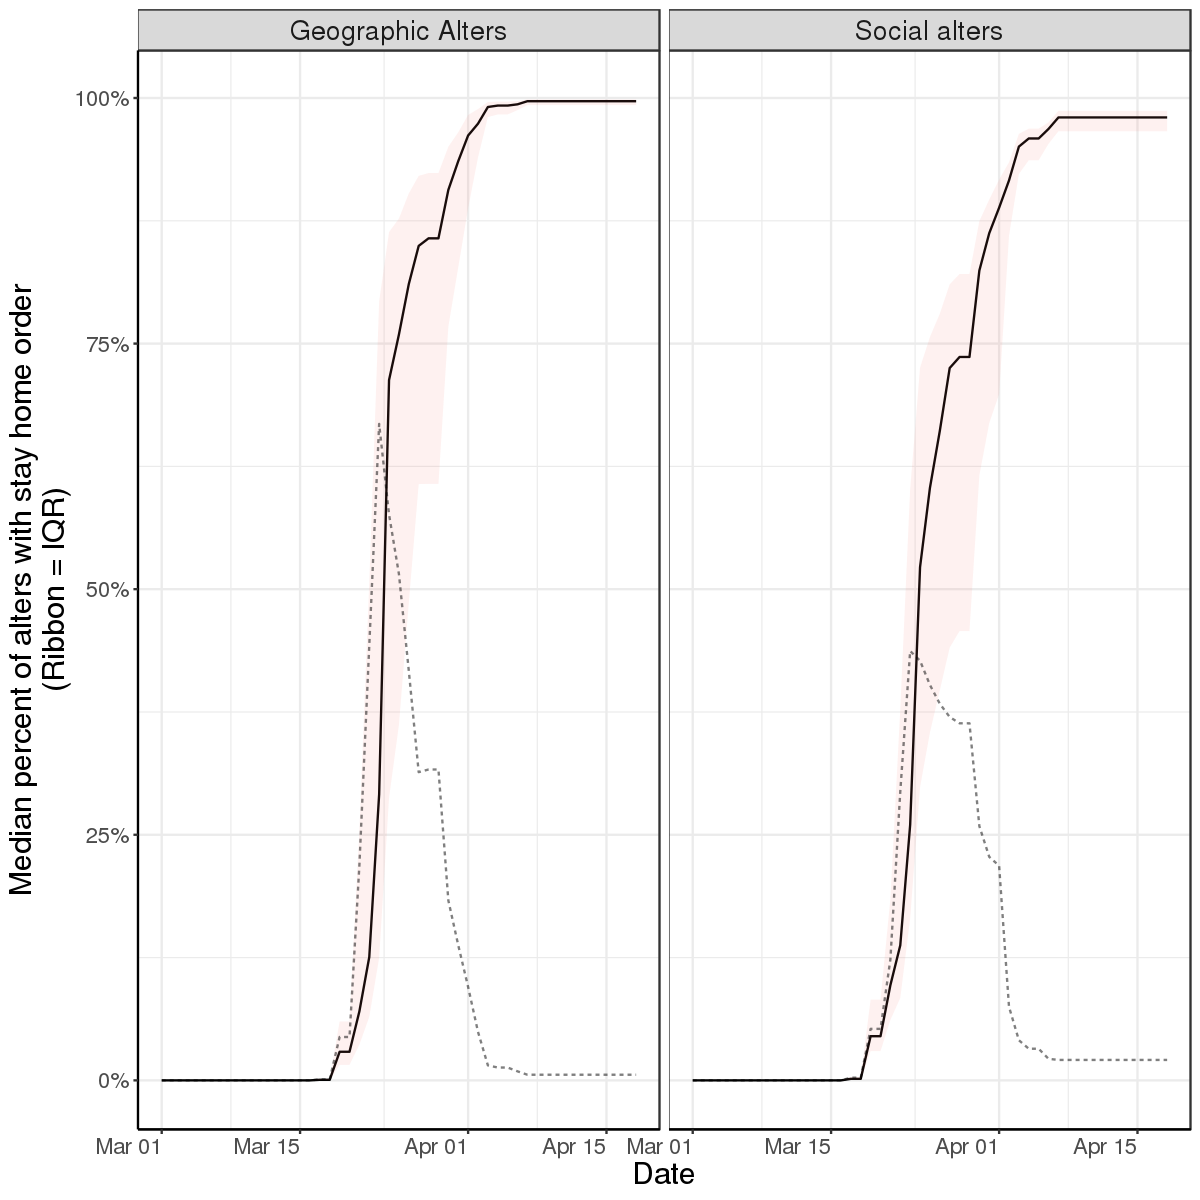

In [55]:
policy_change_time_series <- rbind(panel %>% 
  group_by(ds) %>% 
  summarise(mean_share_alter_sh = wtd.quantile(alter_sh, n, .5),
            share_alter_sh_25 = wtd.quantile(alter_sh, n, .25),
            share_alter_sh_75 = wtd.quantile(alter_sh, n, .75)) %>% 
  ungroup() %>% 
  mutate(pop = 'Social alters'),
      panel %>% 
  group_by(ds) %>% 
  summarise(mean_share_alter_sh = wtd.quantile(geo_alter_sh, n, .5),
            share_alter_sh_25 = wtd.quantile(geo_alter_sh, n, .25),
            share_alter_sh_75 = wtd.quantile(geo_alter_sh, n, .75)) %>% 
  ungroup() %>% 
  mutate(pop = 'Geographic Alters')) %>% 
  mutate(iqr = share_alter_sh_75 - share_alter_sh_25) %>%
  ggplot(., aes(x=ds, y=mean_share_alter_sh)) + geom_line() + facet_wrap(~pop) + 
  geom_ribbon(aes(ymin=share_alter_sh_25, ymax=share_alter_sh_75, fill='blue'), alpha=.1) + 
ylab('Median percent of alters with stay home order\n(Ribbon = IQR)') + 
xlab('Date') + geom_line(aes(x=ds, y=iqr), linetype='dashed', alpha=.5) + 
scale_y_continuous(labels=percent) + guides(fill=FALSE) + 
  theme(axis.text.x = element_text(hjust = 1, size=13),
        axis.text.y = element_text(size=13),
        axis.title = element_text(size=18),
        #strip.text.x = element_blank(),
        #strip.text.y = element_text(size=16),
        panel.background = element_blank(),
        axis.line = element_line(colour = "black"),
        #strip.placement.y='top',
        #strip.background=element_blank(),
        strip.text.x.top = element_text(size=16),
        legend.position="bottom"
       )
  policy_change_time_series

In [56]:
# Write plot to output
ggsave(
  paste0("../output/policy_change_time_series.pdf"),
  plot = policy_change_time_series,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 7,
  height = 5,
  units = c("in"),
  dpi = 200,
  limitsize = FALSE,
  useDingbats=FALSE
)

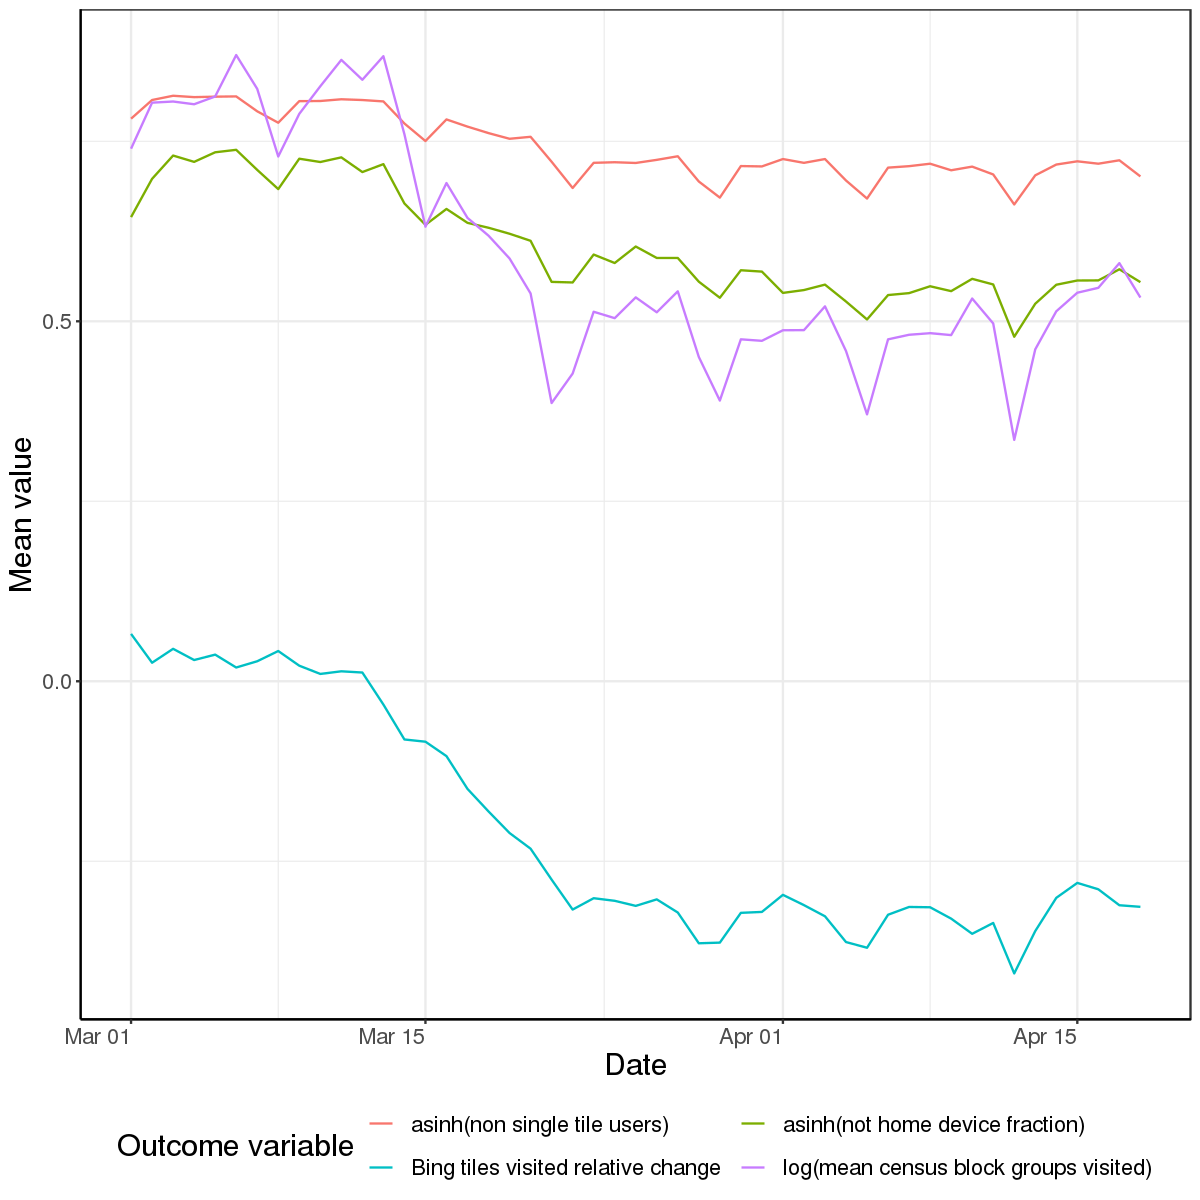

In [57]:
outcomes_over_time <- panel %>% 
  group_by(ds) %>% 
  summarise(`asinh(not home device fraction)` = weighted.mean(ash_nhd, n),
            `asinh(non single tile users)` = weighted.mean(ash_rnstu, n),
            `log(mean census block groups visited)` = weighted.mean(log_mcbgv, n),
           `Bing tiles visited relative change` = weighted.mean(fb_btvrc, n)) %>% 
tidyr::gather("outcome", "mean_value", -ds) %>% 
ggplot(., aes(x=ds, y=mean_value, color=outcome)) + geom_line() + 
  theme(axis.text.x = element_text(hjust = 1, size=13),
        axis.text.y = element_text(size=13),
        axis.title = element_text(size=18),
        #strip.text.x = element_blank(),
        #strip.text.y = element_text(size=16),
        panel.background = element_blank(),
        axis.line = element_line(colour = "black"),
        #strip.placement.y='top',
        #strip.background=element_blank(),
        strip.text.x.top = element_text(size=16),
        legend.position="bottom",
        legend.title = element_text(size=18),
        legend.text = element_text(size=13)
       ) + labs(color='Outcome variable') + ylab('Mean value') + xlab('Date') + 
guides(color=guide_legend(nrow=2,byrow=TRUE))
outcomes_over_time

In [58]:
# Write plot to output
ggsave(
  paste0("../output/outcomes_over_time.pdf"),
  plot = outcomes_over_time,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 8,
  height = 5,
  units = c("in"),
  dpi = 200,
  limitsize = FALSE,
  useDingbats=FALSE
)

In [52]:
panel %>% 
  dplyr::select(sg_mcbgv, sg_nhd, fb_btvrc, fb_rnstu) -> outcomes_correlation_df
names(outcomes_correlation_df) <- c('Mean census block\ngroups visited',
                                   'Non-home device\nfraction',
                                   'Bing tiles visited\nrelative change',
                                   'Non-single tile users')

In [53]:
png(
  "../output/outcomes_correlation.png",
  width     = 5,
  height    = 5,
  units     = "in",
  res       = 200,
)

outcomes_correlation <- chart.Correlation(outcomes_correlation_df, histogram=TRUE, pch=19, col='grey')

dev.off()

png 
  2